# Prepare Data

In [21]:
import pandas as pd

pd.options.mode.copy_on_write = True

YEARS = [2023]
TZ = 'Europe/Berlin'

df = pd.read_csv(f'data_Energy_Germany/Realised_Demand_Germany_{YEARS[0]}.csv', sep=';')

df.drop(['Residual Load [MWh]', 'Pumped Storage [MWh]', 'Date to'], axis=1, inplace=True)
df.rename(columns={'Date from': 'date_from', 'Total (Grid Load) [MWh]': 'grid_load'}, inplace=True)

# convert to datetime columns

df['date_from'] = pd.to_datetime(df['date_from'], format='%d.%m.%y %H:%M').dt.tz_localize(TZ, ambiguous='infer')

# convert to float column
df.grid_load = df.grid_load.str.replace('.', '').str.replace(',', '.')  # clean float representation
df = df.astype({'grid_load': float})

for col in df.columns:
    if any(df.date_from.isna()):
        print(f'WARNING: Missing value in column {col} detected!')
df.head()

,date_from,grid_load
0,2023-01-01 00:00:00+01:00,9720.75
1,2023-01-01 00:15:00+01:00,9641.25
2,2023-01-01 00:30:00+01:00,9609.50
3,2023-01-01 00:45:00+01:00,9565.00
4,2023-01-01 01:00:00+01:00,9473.50


In [22]:
from holidays.utils import country_holidays


# === categorize days ===

german_holidays = country_holidays('DE', years=YEARS)
holiday_dates = set(german_holidays.keys())

def is_sunday_or_holiday(timestamp):
    return timestamp.date() in holiday_dates or timestamp.day_name() == 'Sunday'

def gen_saturday_col(df):
    return df.date_from.map(lambda ts: ts.day_name() == 'Saturday') & ~df.is_sunday_or_holiday

df = df.assign(is_sunday_or_holiday=df.date_from.map(is_sunday_or_holiday))
df = df.assign(is_saturday_and_not_holiday=gen_saturday_col(df))
df = df.assign(is_workday=(~df.is_sunday_or_holiday & ~df.is_saturday_and_not_holiday))

df.head()

,date_from,grid_load,is_sunday_or_holiday,is_saturday_and_not_holiday,is_workday
0,2023-01-01 00:00:00+01:00,9720.75,True,False,False
1,2023-01-01 00:15:00+01:00,9641.25,True,False,False
2,2023-01-01 00:30:00+01:00,9609.50,True,False,False
3,2023-01-01 00:45:00+01:00,9565.00,True,False,False
4,2023-01-01 01:00:00+01:00,9473.50,True,False,False


In [23]:
# === add heating period ===

# heating period is approx. from October to March, i.e. not April (4) to September (9)
df = df.assign(is_heating_period=df.date_from.map(lambda ts: ts.month not in range(4, 9+1)))

df.head()

,date_from,grid_load,is_sunday_or_holiday,is_saturday_and_not_holiday,is_workday,is_heating_period
0,2023-01-01 00:00:00+01:00,9720.75,True,False,False,True
1,2023-01-01 00:15:00+01:00,9641.25,True,False,False,True
2,2023-01-01 00:30:00+01:00,9609.50,True,False,False,True
3,2023-01-01 00:45:00+01:00,9565.00,True,False,False,True
4,2023-01-01 01:00:00+01:00,9473.50,True,False,False,True


In [40]:
grid_load_dict = dict(zip(df.date_from, df.grid_load))

AttributeError: 'DataFrame' object has no attribute 'date_from'

In [25]:
from datetime import timedelta

# === add lagged values for input and output ===


def add_one_week(ts):
    return add_timedelta(ts, timedelta(weeks=1))

def sub_one_year(ts):
    # todo: decide how to handle leap years
    return add_timedelta(ts, timedelta(days=-365))

def add_timedelta(ts, td):
    # based on: https://www.hacksoft.io/blog/handling-timezone-and-dst-changes-with-python
    ts_utc = ts.astimezone('UTC')
    ts_next_week_utc = ts_utc + td
    ts_next_week = ts_next_week_utc.astimezone(TZ)
    dst_offset_diff = ts.dst() - ts_next_week.dst()
    ts_next_week += dst_offset_diff
    return ts_next_week


df_points_per_hour = 4

df.rename(columns={'date_from': 'ts_last_week', 'grid_load': 'load_last_week'}, inplace=True)

df = df.assign(ts_now=df.ts_last_week.map(add_one_week))

# we ignore DST changes for 1h lags, but account for them for lags >= 1d
df = df.assign(ts_last_hour=df.ts_now.shift(df_points_per_hour))
df = df.assign(ts_next_hour=df.ts_now.shift(-df_points_per_hour))
df.dropna(inplace=True, ignore_index=True)
df.head()

,ts_last_week,load_last_week,is_sunday_or_holiday,is_saturday_and_not_holiday,is_workday,is_heating_period,ts_now,ts_last_hour,ts_next_hour
0,2023-01-01 01:00:00+01:00,9473.50,True,False,False,True,2023-01-08 01:00:00+01:00,2023-01-08 00:00:00+01:00,2023-01-08 02:00:00+01:00
1,2023-01-01 01:15:00+01:00,9448.00,True,False,False,True,2023-01-08 01:15:00+01:00,2023-01-08 00:15:00+01:00,2023-01-08 02:15:00+01:00
2,2023-01-01 01:30:00+01:00,9550.25,True,False,False,True,2023-01-08 01:30:00+01:00,2023-01-08 00:30:00+01:00,2023-01-08 02:30:00+01:00
3,2023-01-01 01:45:00+01:00,9463.75,True,False,False,True,2023-01-08 01:45:00+01:00,2023-01-08 00:45:00+01:00,2023-01-08 02:45:00+01:00
4,2023-01-01 02:00:00+01:00,9358.50,True,False,False,True,2023-01-08 02:00:00+01:00,2023-01-08 01:00:00+01:00,2023-01-08 03:00:00+01:00


In [44]:
# === remove timestamps for which no grid load data is available

ts_with_data_min, ts_with_data_max = df.ts_last_week.min(), df.ts_last_week.max()

for col in ['ts_now', 'ts_last_hour', 'ts_next_hour']:
    out_of_bounds_index = df[(df[col] < ts_with_data_min) | (df[col] > ts_with_data_max)].index
    df.drop(index=out_of_bounds_index, inplace=True)
df

,ts_last_week,load_last_week,is_sunday_or_holiday,is_saturday_and_not_holiday,is_workday,is_heating_period,ts_now,ts_last_hour,ts_next_hour
0,2023-01-01 01:00:00+01:00,9473.50,True,False,False,True,2023-01-08 01:00:00+01:00,2023-01-08 00:00:00+01:00,2023-01-08 02:00:00+01:00
1,2023-01-01 01:15:00+01:00,9448.00,True,False,False,True,2023-01-08 01:15:00+01:00,2023-01-08 00:15:00+01:00,2023-01-08 02:15:00+01:00
2,2023-01-01 01:30:00+01:00,9550.25,True,False,False,True,2023-01-08 01:30:00+01:00,2023-01-08 00:30:00+01:00,2023-01-08 02:30:00+01:00
3,2023-01-01 01:45:00+01:00,9463.75,True,False,False,True,2023-01-08 01:45:00+01:00,2023-01-08 00:45:00+01:00,2023-01-08 02:45:00+01:00
4,2023-01-01 02:00:00+01:00,9358.50,True,False,False,True,2023-01-08 02:00:00+01:00,2023-01-08 01:00:00+01:00,2023-01-08 03:00:00+01:00
...,...,...,...,...,...,...,...,...,...
33679,2023-12-17 20:45:00+01:00,13252.50,True,False,False,True,2023-12-24 20:45:00+01:00,2023-12-24 19:45:00+01:00,2023-12-24 21:45:00+01:00
33680,2023-12-17 21:00:00+01:00,13143.25,True,False,False,True,2023-12-24 21:00:00+01:00,2023-12-24 20:00:00+01:00,2023-12-24 22:00:00+01:00
33681,2023-12-17 21:15:00+01:00,13051.75,True,False,False,True,2023-12-24 21:15:00+01:00,2023-12-24 20:15:00+01:00,2023-12-24 22:15:00+01:00
33682,2023-12-17 21:30:00+01:00,13003.75,True,False,False,True,2023-12-24 21:30:00+01:00,2023-12-24 20:30:00+01:00,2023-12-24 22:30:00+01:00


In [51]:
# === add grid load columns by time stamp ===

df = df.assign(load_last_hour=df.ts_last_hour.map(lambda ts: grid_load_dict[ts]))
df = df.assign(load_now=df.ts_now.map(lambda ts: grid_load_dict[ts]))
df = df.assign(load_next_hour=df.ts_next_hour.map(lambda ts: grid_load_dict[ts]))

# remove unneeded time stamp columns
df.drop(['ts_last_week', 'ts_last_hour', 'ts_next_hour'], axis=1, inplace=True)

df

,load_last_week,is_sunday_or_holiday,is_saturday_and_not_holiday,is_workday,is_heating_period,ts_now,load_last_hour,load_now,load_next_hour
0,9473.50,True,False,False,True,2023-01-08 01:00:00+01:00,10807.25,10375.25,10070.50
1,9448.00,True,False,False,True,2023-01-08 01:15:00+01:00,10703.75,10232.75,10005.75
2,9550.25,True,False,False,True,2023-01-08 01:30:00+01:00,10627.00,10189.25,9984.50
3,9463.75,True,False,False,True,2023-01-08 01:45:00+01:00,10510.25,10119.50,9963.75
4,9358.50,True,False,False,True,2023-01-08 02:00:00+01:00,10375.25,10070.50,10013.00
...,...,...,...,...,...,...,...,...,...
33679,13252.50,True,False,False,True,2023-12-24 20:45:00+01:00,11987.50,11502.25,11318.50
33680,13143.25,True,False,False,True,2023-12-24 21:00:00+01:00,11870.00,11488.75,11497.00
33681,13051.75,True,False,False,True,2023-12-24 21:15:00+01:00,11734.00,11432.75,11384.00
33682,13003.75,True,False,False,True,2023-12-24 21:30:00+01:00,11663.75,11377.00,11266.50


# LinReg

In [6]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split


# prepare data

n_steps_ahead = df_points_per_hour  # predict next hour    # 4 * 24  # 1 day ahead

arr = df['grid_load']
X = np.array(arr[:-n_steps_ahead]).reshape(-1, 1)  # (n_samples, n_features)
y = np.array(arr[n_steps_ahead:]).reshape(-1, 1)  # (n_samples, n_targets)
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17514, 1), (17514, 1), (17514, 1), (17514, 1))

In [7]:
# === perform regression ===

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Coefficients: 
 [[0.96706788]]
Mean squared error: 346287.98
Coefficient of determination: 0.93


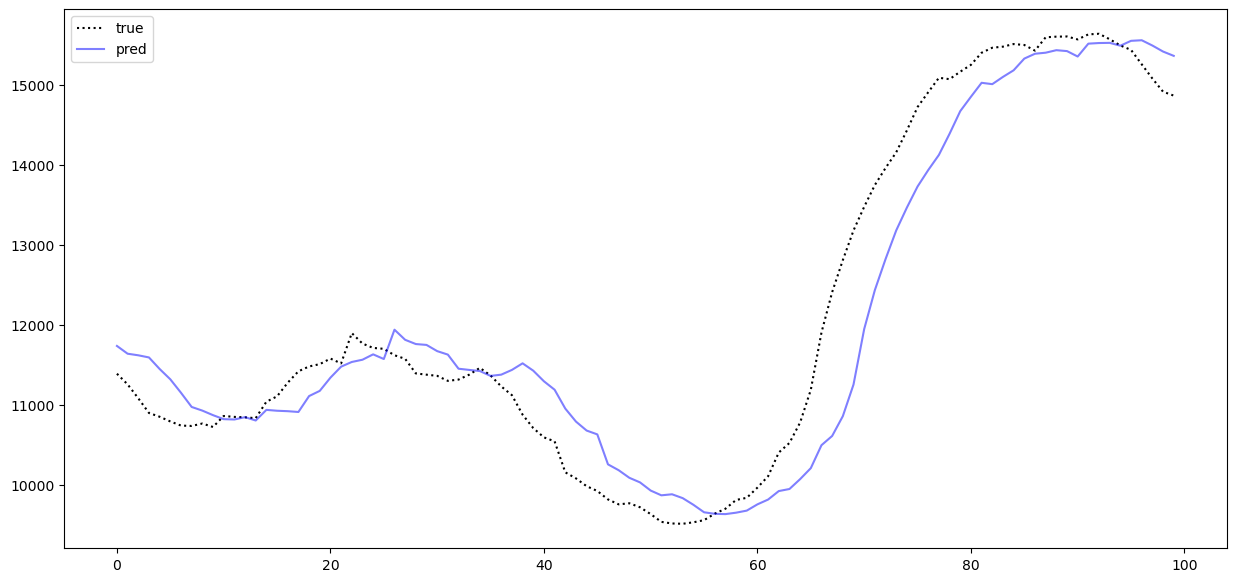

In [8]:
# === plot ===

x_plot = np.arange(X_test.size)

# Plot outputs

fig, ax = plt.subplots(figsize=(15,7))

n_points = 100

plt.plot(x_plot[:n_points], y_test[:n_points], color="black", label='true', linestyle='dotted')
# plt.plot(x_plot[:n_points], X_test[:n_points], color="red", label='inputs', linestyle='dashed')
plt.plot(x_plot[:n_points], y_pred[:n_points], color="blue", label='pred', alpha=0.5)

# plt.xticks(())
# plt.yticks(())

plt.legend()
plt.show()